# **Group 4 Final Project: Sentiment analysis of suicide ideation on social media PART 1**
    Jin Chen / Kerin Wu / Minh Khoi Quach / Rhyon Tze Han Lu 2024-12



## Basic Setup

In [ ]:
# File directory
from google.colab import drive
drive.mount('/content/drive')  # Add My Drive/<>

import os
os.chdir('/content/drive/My Drive')
os.chdir('NLP Group/')

Mounted at /content/drive


In [ ]:
# Import all necessary libraries
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize,PunktSentenceTokenizer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score,precision_score, recall_score, roc_auc_score, log_loss, roc_curve, auc
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
!pip install wordcloud
from wordcloud import WordCloud
from gensim.models import Word2Vec
from collections import Counter
import time
from sklearn.decomposition import LatentDirichletAllocation
import torch
from transformers import BertModel, BertTokenizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

!pip install contractions
import contractions

!pip install autocorrect
from autocorrect import Speller

Populating the interactive namespace from numpy and matplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=88cbe5dbb26c916f169eb5a066aafb84d419dd34028e3fdbe1445c7e29d30218
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


# Dataset B

## Data Preprocessing
    The dataset has 348,124 reddit posts, 1 empty text, 14 empty labels and completely balanced.

In [ ]:
# Read in dataset B
data=pd.read_csv('SuicideAndDepression_Detection.csv')
data

,text,class
0,Does life actually work for most / non-depress...,depression
1,I found my friend's bodyIt was almost nine yea...,depression
2,Ex Wife Threatening SuicideRecently I left my ...,SuicideWatch
3,Am I weird I don't get affected by compliments...,teenagers
4,Finally 2020 is almost over... So I can never ...,teenagers
...,...,...
348119,You how you can tell i have so many friends an...,teenagers
348120,pee probably tastes like salty tea😏💦‼️ can som...,teenagers
348121,The usual stuff you find hereI'm not posting t...,SuicideWatch
348122,"I confronted my mother. Extremely isolated, wi...",depression


#### Checking shape, null, class distribution

In [ ]:
# check how many posts in this dataset
data.shape

(348124, 2)

In [ ]:
# check how many labels and what are the unique labels
data['class'].value_counts()

,count
class,
SuicideWatch,116037
teenagers,116037
depression,116036


In [ ]:
# check null values
data.isnull().sum()

,0
text,1
class,14


### Text Cleaning

In [ ]:
# Create a copy of data with stratified sampling for 10% of original dataset, equal pecentage for each class
df = data.groupby('class', group_keys=False).apply(lambda x: x.sample(frac=1)).reset_index(drop=True)

# Handling null data
df = df.dropna(subset=['text', 'class'])
df = df[df['text'].str.strip() != '']
df = df[df['class'].str.strip() != '']

# Change the column name from 'class' to label'
df = df.rename(columns={'class': 'label'})

# Replace 'teenagers' with 'non-suicide', 'SuicideWatch' with 'suicide' in column label
df['label'] = df['label'].replace({'teenagers': 'non-suicide', 'SuicideWatch': 'suicide'})

# Remove HTML in the text column
df['cleaned_text'] = df['text'].str.replace(r'<[^<>]*>', '', regex=True)

# Remove new lines in the text column
df['cleaned_text'] = df['cleaned_text'].str.replace('\n', ' ')

# Remove URLs in the text column
df['cleaned_text'] = df['cleaned_text'].str.replace(r'http\S+|www.\S+', '', regex=True)

# Remove special characters (including emojis) with space in the text column
df['cleaned_text'] = df['cleaned_text'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

# Convert the 'cleaned_text' column to string type to ensure all values are strings
df['cleaned_text'] = df['cleaned_text'].astype(str)

# Replacing contractions using contraction dictionary
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: contractions.fix(x))

# Remove english stopwords with nltk, except for 'I'
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.discard('i')

# Remove custom stopwords as navigation or command terms, system feedback words, common internet slang
simple_stopwords = set([
    'ok', 'like and share', 'followers', 'repost', 'click', 'press', 'enter', 'submit', 'loading', 'processing', 'completed',
    'lol', 'lmao', 'btw', 'brb', 'fb', 'Welp'])
stop_words.update(simple_stopwords)
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Add a space in a word with capital letter in between, e.g bodyIt
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'([a-z])([A-Z])', r'\1 \2', x))

# Convert words to singular
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Apply negation tagging
#df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'\b(?:not|n\'t)\b', 'not_', x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Separate due to long runtime
# Lemmatization using SpaCy
nlp = spacy.load('en_core_web_sm')
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

In [ ]:
df.head()

,text,label,cleaned_text
0,I've been in bed all day and haven't had a pro...,suicide,I bed day proper meal 3 year my family disown ...
1,I so wish I could be someone else right now......,suicide,I wish I could someone else right now I love l...
2,"""And I'm at an all time low""Hi, Reddit Users. ...",suicide,I time low hi reddit Users I sure I go life pl...
3,Caught myself already writing a note.Life is g...,suicide,catch already write note life get tough right ...
4,I'm a freakAm I the only one who feels like a ...,suicide,I freak be I one feel like freak I mess head I...


### Try some examples after cleaning

In [ ]:
# get the row with text containing specific patterns/words/characters/contractions - emojis
df[df['text'].str.contains("pee probably tastes like salty tea", na=False)]

,text,label,cleaned_text
242982,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,pee probably taste like salty tea someone drin...


In [ ]:
# get the row with text containing specific patterns/words/characters/contractions - html/URL links
df[df['text'].str.contains("http://imgur.com/xtAMc3x", na=False)]

,text,label,cleaned_text
194565,I baked muffins todayIt may seem like a stupid...,depression,I bake muffin today it may seem like stupid li...


## Sentiment Analysis

In [ ]:
from zlib import DEF_BUF_SIZE
# Sentiment Score the Text using this Dictionary from Harvard Inquirer
f = open('inqdict.txt')
HIDict = f.read()
HIDict = HIDict.splitlines()

# Extract all the lines that contain the Pos tag
HIDict = HIDict[1:]
poswords = [j for j in HIDict if "Pos" in j]  #using a list comprehension
poswords = [j.split()[0] for j in poswords]
poswords = [j.split("#")[0] for j in poswords]
poswords = unique(poswords)
poswords = [j.lower() for j in poswords]
print(poswords[:20])
print(len(poswords))

# Extract all the lines that contain the Neg tag
negwords = [j for j in HIDict if "Neg" in j]  #using a list comprehension
negwords = [j.split()[0] for j in negwords]
negwords = [j.split("#")[0] for j in negwords]
negwords = unique(negwords)
negwords = [j.lower() for j in negwords]
print(negwords[:20])
print(len(negwords))

# Make a copy df for sentiment analysis
df_sentiment = df.copy()
# Match text to poswords, negwords, use the set operators
df_sentiment['pos_score'] = df_sentiment['cleaned_text'].apply(lambda x: len(set(x.split()) & set(poswords)))
df_sentiment['neg_score'] = df_sentiment['cleaned_text'].apply(lambda x: len(set(x.split()) & set(negwords)))
df_sentiment['sentiment_score'] = df_sentiment['pos_score'] - df_sentiment['neg_score']
df_sentiment['sentiment_label'] = df_sentiment['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')
df_sentiment.head()


['abide', 'able', 'abound', 'absolve', 'absorbent', 'absorption', 'abundance', 'abundant', 'accede', 'accentuate', 'accept', 'acceptable', 'acceptance', 'accessible', 'accession', 'acclaim', 'acclamation', 'accolade', 'accommodate', 'accommodation']
1646
['abandon', 'abandonment', 'abate', 'abdicate', 'abhor', 'abject', 'abnormal', 'abolish', 'abominable', 'abrasive', 'abrupt', 'abscond', 'absence', 'absent', 'absent-minded', 'absentee', 'absurd', 'absurdity', 'abuse', 'abyss']
2120


,text,label,cleaned_text,pos_score,neg_score,sentiment_score,sentiment_label
0,I've been in bed all day and haven't had a pro...,suicide,I bed day proper meal 3 year my family disown ...,20,25,-5,negative
1,I so wish I could be someone else right now......,suicide,I wish I could someone else right now I love l...,9,6,3,positive
2,"""And I'm at an all time low""Hi, Reddit Users. ...",suicide,I time low hi reddit Users I sure I go life pl...,58,69,-11,negative
3,Caught myself already writing a note.Life is g...,suicide,catch already write note life get tough right ...,34,42,-8,negative
4,I'm a freakAm I the only one who feels like a ...,suicide,I freak be I one feel like freak I mess head I...,16,26,-10,negative


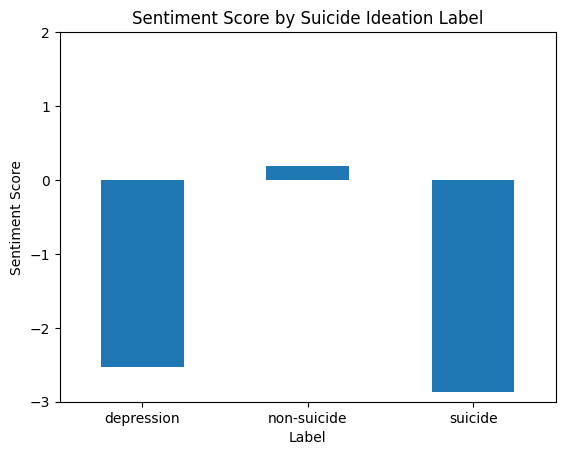

In [ ]:
# plot average sentiment score by label
df_sentiment.groupby('label')['sentiment_score'].mean().plot(kind='bar')
plt.title('Sentiment Score by Suicide Ideation Label')
plt.xlabel('Label')
plt.ylabel('Sentiment Score')
plt.ylim(-3, 2)
plt.xticks(rotation=0)
plt.show()

In [ ]:
# checking number of posts by labels
df_sentiment['label'].value_counts()

,count
label,
suicide,116037
non-suicide,116037
depression,116035


### WordCloud (two versions: all words vs. sentiment words only)

In [ ]:
# ALL Words
# Build wordcloud for three classes
#df_suicide = df[df['label'] == 'suicide']
#df_non_suicide = df[df['label'] == 'non-suicide']
#df_depression = df[df['label'] == 'depression']
#df_suicide_text = ' '.join(set(df_suicide['cleaned_text']))
#df_non_suicide_text = ' '.join(set(df_non_suicide['cleaned_text']))
#df_depression_text = ' '.join(set(df_depression['cleaned_text']))
#df_suicide_wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10, max_words=100).generate(df_suicide_text)
#df_non_suicide_wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10, max_words=100).generate(df_non_suicide_text)
#df_depression_wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10, max_words=100).generate(df_depression_text)

In [ ]:
# Helper function to count word frequencies, excluding specific words
def calculate_word_frequencies(text_series, exclude_words=None):
    if exclude_words is None:
        exclude_words = []
    all_words = ' '.join(text_series).split()  # Split all texts into individual words
    filtered_words = [word for word in all_words if word.lower() not in exclude_words]  # Exclude specific words
    word_counts = Counter(filtered_words)  # Count word frequencies
    return word_counts  # Return the frequency dictionary

# Words to exclude
exclude_words = ["i"]

# Build word frequency dictionaries for three classes
df_suicide_word_frequencies = calculate_word_frequencies(df_suicide['cleaned_text'], exclude_words)
df_non_suicide_word_frequencies = calculate_word_frequencies(df_non_suicide['cleaned_text'], exclude_words)
df_depression_word_frequencies = calculate_word_frequencies(df_depression['cleaned_text'], exclude_words)

# Generate word clouds based on word frequencies
df_suicide_wordcloud = WordCloud(width=800, height=400, background_color='white',
                                 min_font_size=10, max_words=200).generate_from_frequencies(df_suicide_word_frequencies)
df_non_suicide_wordcloud = WordCloud(width=800, height=400, background_color='white',
                                     min_font_size=10, max_words=200).generate_from_frequencies(df_non_suicide_word_frequencies)
df_depression_wordcloud = WordCloud(width=800, height=400, background_color='white',
                                    min_font_size=10, max_words=200).generate_from_frequencies(df_depression_word_frequencies)



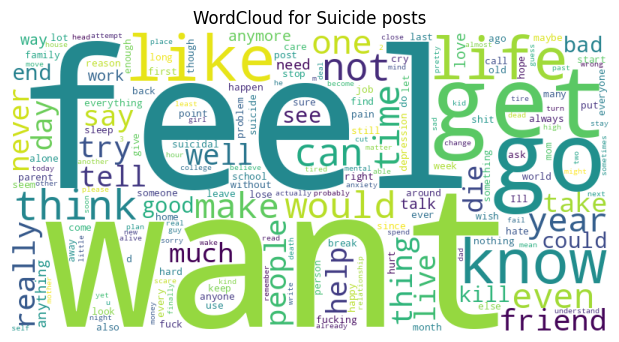

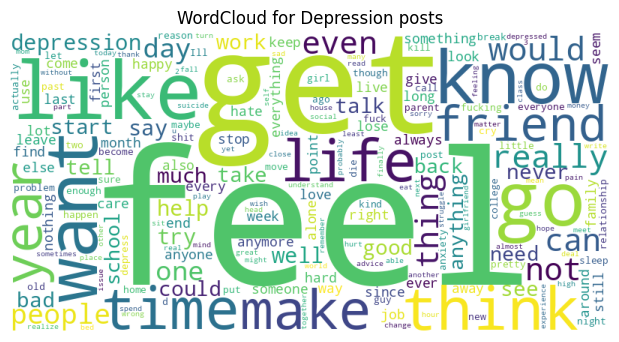

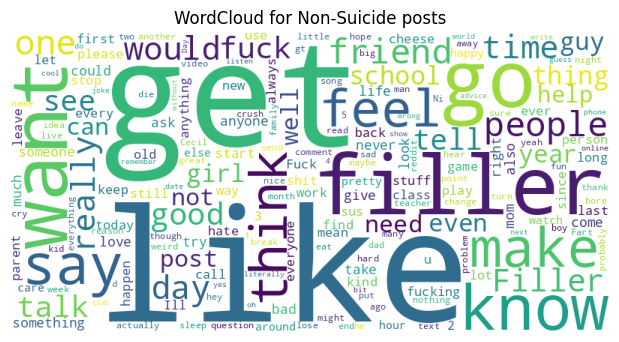

In [ ]:
# plot wordcloud for suicide
plt.figure(figsize=(6, 8), facecolor=None)
plt.imshow(df_suicide_wordcloud)
plt.title('WordCloud for Suicide posts')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# plot wordcloud for depression
plt.figure(figsize=(6, 8), facecolor=None)
plt.imshow(df_depression_wordcloud)
plt.title('WordCloud for Depression posts')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# plot wordcloudd for non-suicide
plt.figure(figsize=(6, 8), facecolor=None)
plt.imshow(df_non_suicide_wordcloud)
plt.title('WordCloud for Non-Suicide posts')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [ ]:
# Sentiment Words only
# Get sentiment words for each post
df_sentiment['sentiment_words'] = df_sentiment['cleaned_text'].apply(lambda x: [word for word in x.split() if word in poswords or word in negwords])

In [ ]:
# Build wordcloud using df_sentiment for each class with unique words
#df_suicide_sentiment_text = ' '.join(df_sentiment[df_sentiment['label'] == 'suicide']['sentiment_words'].apply(lambda x: ' '.join(set(x))))
#df_non_suicide_sentiment_text = ' '.join(df_sentiment[df_sentiment['label'] == 'non-suicide']['sentiment_words'].apply(lambda x: ' '.join(set(x))))
#df_depression_sentiment_text = ' '.join(df_sentiment[df_sentiment['label'] == 'depression']['sentiment_words'].apply(lambda x: ' '.join(set(x))))
#df_suicide_sentiment_wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(df_suicide_sentiment_text)
#df_non_suicide_sentiment_wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(df_non_suicide_sentiment_text)
#df_depression_sentiment_wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(df_depression_sentiment_text)

In [ ]:
# Helper function to calculate word frequencies
def calculate_word_frequencies(series_of_word_lists):
    all_words = [word for word_list in series_of_word_lists for word in word_list]  # Flatten the list of lists
    word_counts = Counter(all_words)  # Count word frequencies
    return word_counts  # Return the frequency dictionary

# Build word frequency dictionaries for each class
df_suicide_sentiment_frequencies = calculate_word_frequencies(df_sentiment[df_sentiment['label'] == 'suicide']['sentiment_words'])
df_non_suicide_sentiment_frequencies = calculate_word_frequencies(df_sentiment[df_sentiment['label'] == 'non-suicide']['sentiment_words'])
df_depression_sentiment_frequencies = calculate_word_frequencies(df_sentiment[df_sentiment['label'] == 'depression']['sentiment_words'])

# Generate word clouds based on word frequencies
df_suicide_sentiment_wordcloud = WordCloud(
    width=800, height=400, background_color='white', min_font_size=10, max_words=100
).generate_from_frequencies(df_suicide_sentiment_frequencies)

df_non_suicide_sentiment_wordcloud = WordCloud(
    width=800, height=400, background_color='white', min_font_size=10, max_words=100
).generate_from_frequencies(df_non_suicide_sentiment_frequencies)

df_depression_sentiment_wordcloud = WordCloud(
    width=800, height=400, background_color='white', min_font_size=10, max_words=100
).generate_from_frequencies(df_depression_sentiment_frequencies)


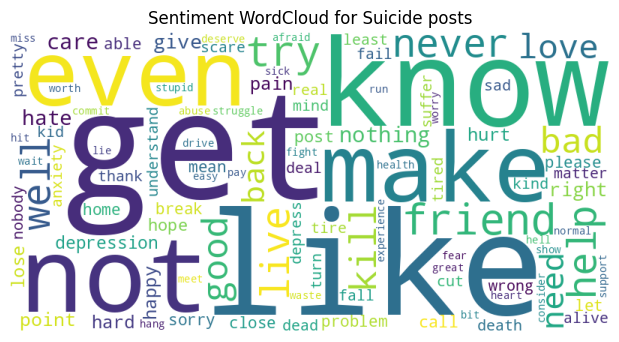

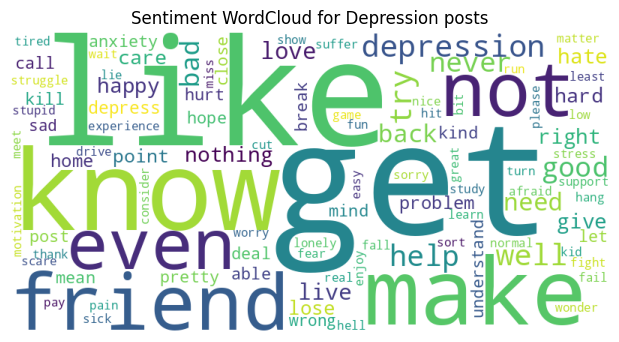

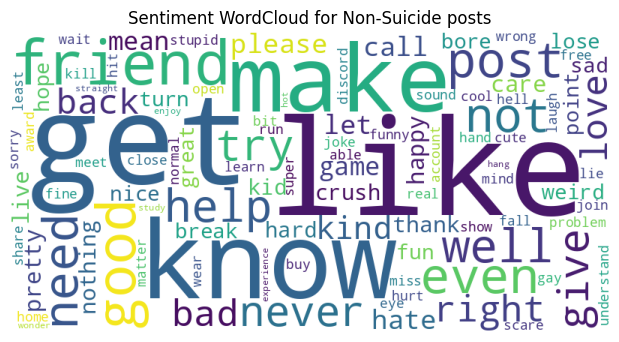

In [ ]:
# plot wordcloud for suicide
plt.figure(figsize=(6, 8), facecolor=None)
plt.imshow(df_suicide_sentiment_wordcloud)
plt.title('Sentiment WordCloud for Suicide posts')
plt.axis('off')
plt.tight_layout(pad=0)

# plot wordcloud for depression
plt.figure(figsize=(6, 8), facecolor=None)
plt.imshow(df_depression_sentiment_wordcloud)
plt.title('Sentiment WordCloud for Depression posts')
plt.axis('off')
plt.tight_layout(pad=0)

# plot wordcloudd for non-suicide
plt.figure(figsize=(6, 8), facecolor=None)
plt.imshow(df_non_suicide_sentiment_wordcloud)
plt.title('Sentiment WordCloud for Non-Suicide posts')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Word Frequency

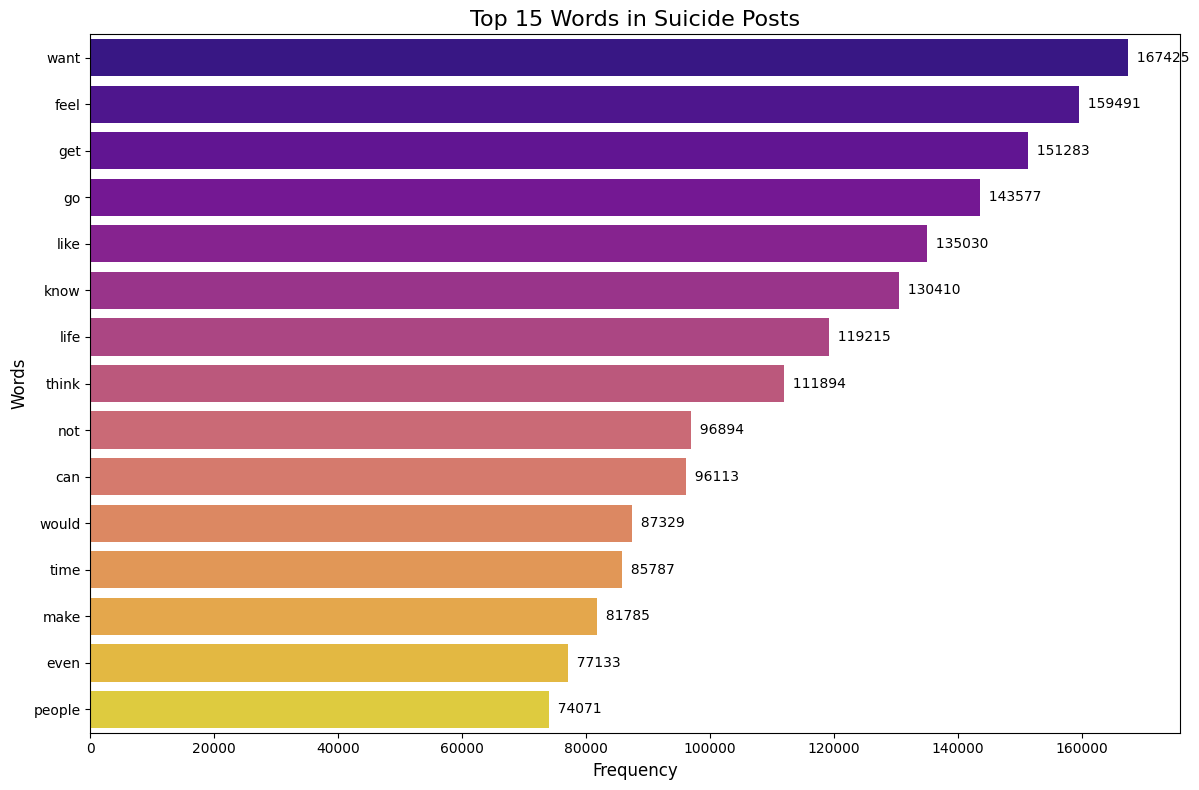

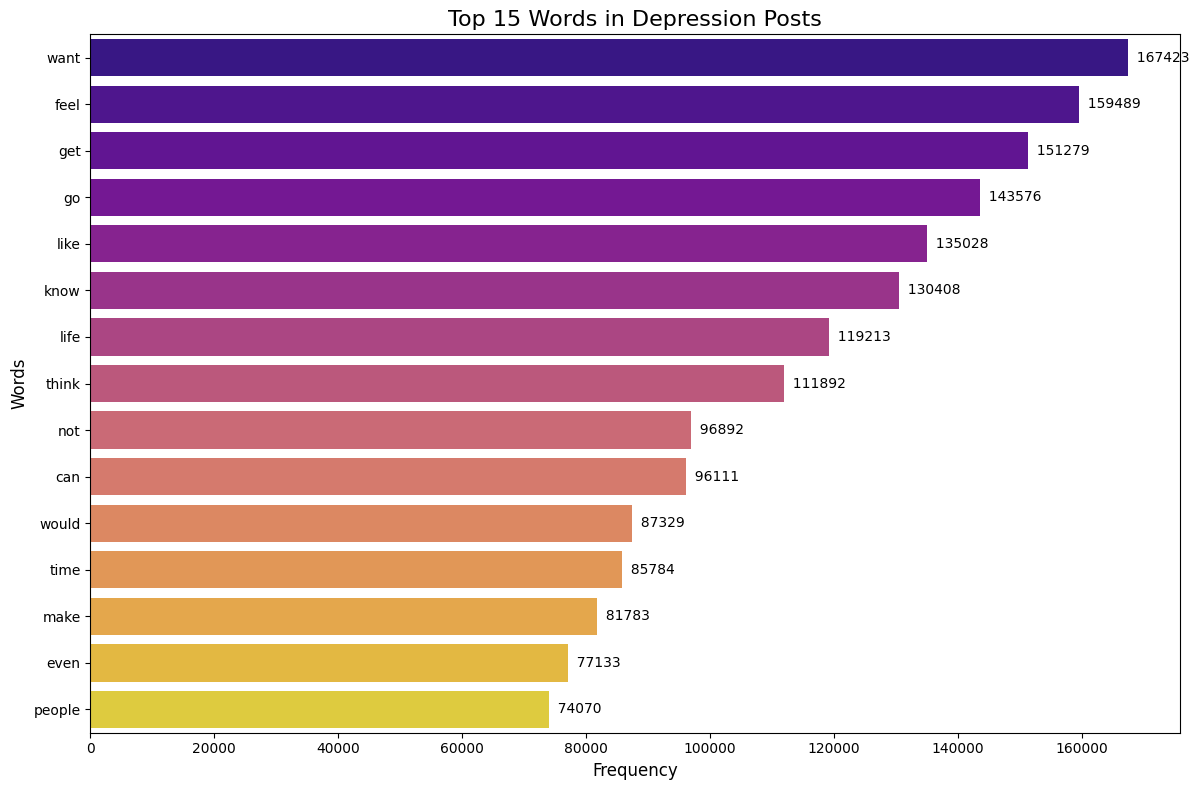

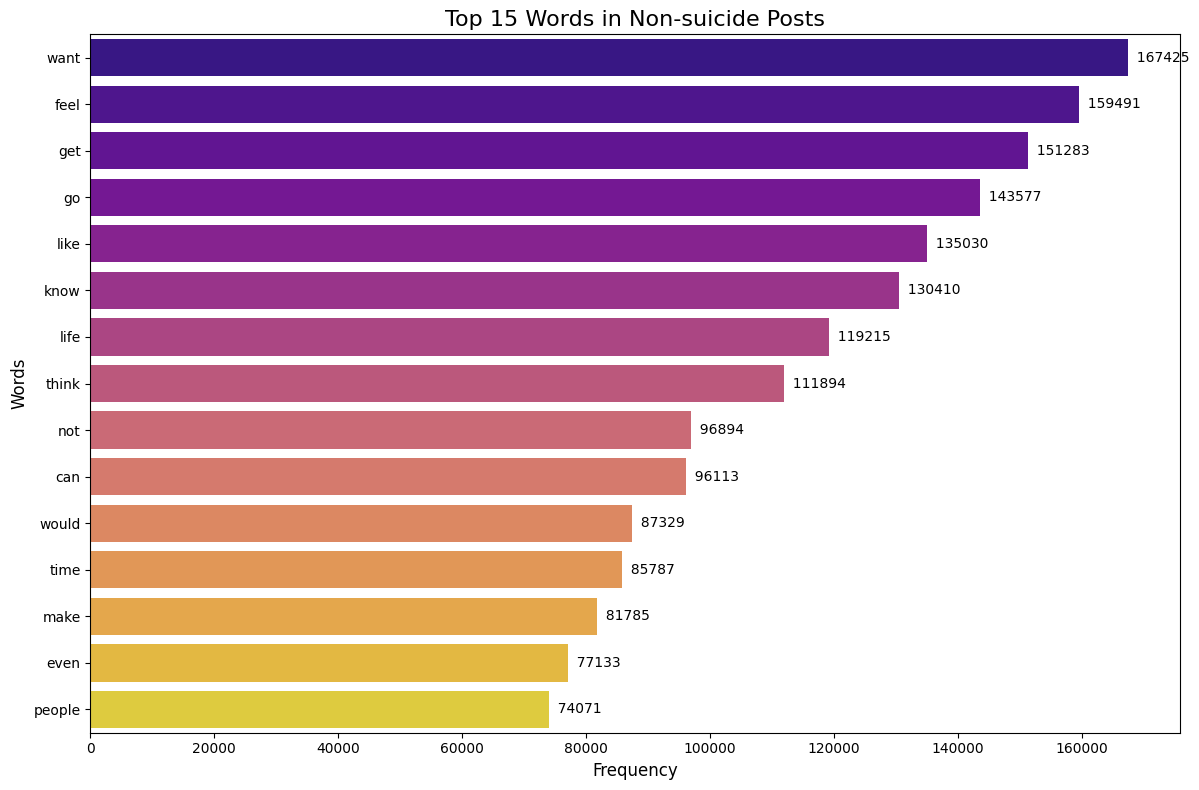

In [ ]:
# Initialize the Vectorizer with a limited number of features and minimum document frequency
vectorizer = CountVectorizer(max_features=10000, min_df=0.01)

# Fit and transform the cleaned text data; maintain as a sparse matrix
# Changed code: Resetting index of 'df' DataFrame before vectorization
X = vectorizer.fit_transform(df.reset_index(drop=True)['cleaned_text'])
feature_names = vectorizer.get_feature_names_out()

# Function to calculate and plot top words from the vectorized data
def plot_top_vectorized_words(label, top_n=15):
    # Filter data for the specified label
    # Changed code: Resetting index of filtered DataFrame to align with 'X'
    label_indices = df[df['label'] == label].reset_index(drop=True).index

    # Sum word counts across all documents of this label
    label_sum = X[label_indices].sum(axis=0)

    # Ensure label_sum is a 1-dimensional array
    if isinstance(label_sum, np.matrix):
        label_sum = label_sum.A1  # Convert matrix to 1D

    # Get top N words sorted by their frequency
    top_words_indices = np.argsort(label_sum)[-top_n:][::-1]
    top_counts = label_sum[top_words_indices]
    top_words = feature_names[top_words_indices]

    # Plotting using seaborn
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x=top_counts, y=top_words, palette=sns.color_palette("plasma", n_colors=top_n))
    plt.title(f'Top {top_n} Words in {label.capitalize()} Posts', fontsize=16)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Words', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Add frequency numbers on each bar
    for i, (count, word) in enumerate(zip(top_counts, top_words)):
        ax.text(count, i, '  {}'.format(count), color='black', ha='left', va='center')

    plt.show()

# Plotting top words for each label
plot_top_vectorized_words('suicide')
plot_top_vectorized_words('depression')
plot_top_vectorized_words('non-suicide')